# CSE151B Final Project- SpaiNN

#### Authors: Álvaro Maza Montesinos & Juan Villanueva Romero

## Import libraries

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import ast
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
# Avoids a warning we were getting when running the code
import warnings
warnings.filterwarnings("ignore")

## Preprocessing

First, we load the training dataset and the metadata provided in class:

In [2]:
# These are all of the files you are given
data = pd.read_csv("train.csv")

In [3]:
csv_df = pd.read_csv('metaData_taxistandsID_name_GPSlocation.csv', sep=',')

We realized that one value of the metadata was wrongly writen, so we had to correct it before proceding with the preprocessing

In [4]:
d = csv_df['Latitude'][40].split('-')
csv_df.at[40, 'Latitude'] = float(d[0])
csv_df.at[40, 'Longitude'] = -float(d[1])
csv_df.loc[40:45]

,ID,Descricao,Latitude,Longitude
40,41,Nevogilde,41.163067,-8.675983
41,42,Nove de Abril,41.1727485684,-8.611784
42,43,Ouro,41.1486110328,-8.648886
43,44,Palácio,41.149617396,-8.625784
44,45,Passeio Alegre,41.1486486007,-8.672795
45,46,Pereira de Melo,41.1786451618,-8.648536


The following two functions were already given in the feature_engineering notebook.

In [5]:
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

def parse_time(x):
  # We are using python's builtin datetime library
  # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

  # Each x is essentially a 1 row, 1 column pandas Series
  dt = datetime.fromtimestamp(x["TIMESTAMP"])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

Now, let's display our data and identify any feature engineering that we can perform

In [6]:
data

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."
...,...,...,...,...,...,...,...,...,...
1710665,1404171463620000698,C,NaN,NaN,20000698,1404171463,A,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-..."
1710666,1404171367620000670,C,NaN,NaN,20000670,1404171367,A,False,"[[-8.610138,41.140845],[-8.610174,41.140935],[..."
1710667,1388745716620000264,C,NaN,NaN,20000264,1388745716,A,False,[]
1710668,1404141826620000248,B,NaN,12.0,20000248,1404141826,A,False,"[[-8.630712,41.154885],[-8.63073,41.154813],[-..."


In [7]:
data.isna().sum()

TRIP_ID               0
CALL_TYPE             0
ORIGIN_CALL     1345900
ORIGIN_STAND     904091
TAXI_ID               0
TIMESTAMP             0
DAY_TYPE              0
MISSING_DATA          0
POLYLINE              0
dtype: int64

As the first step, we can see that there exists a column indicating missing data in each row. Since we have over 1.5 million observations, we have decided to remove observations with NAs:

In [8]:
data = data[data['MISSING_DATA'] == False]

Also, now that it is no longer useful we will remove the MISSING_DATA column, as well as the TRIP_ID since it is unique for every observation, and the ORIGIN_CALL since almost all the column is full of NAs.

In [9]:
data = data.drop('MISSING_DATA', axis=1)
data = data.drop('TRIP_ID', axis=1)
#data = data.drop('CALL_TYPE', axis=1)
data = data.drop('ORIGIN_CALL', axis=1)

Finally, we will only keep the three last digits of the taxi ID:

In [10]:
data['TAXI_ID']=data['TAXI_ID'].astype(str).str[-3:]

In [11]:
data.head()

,CALL_TYPE,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,POLYLINE
0,C,NaN,589,1372636858,A,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,B,7.0,596,1372637303,A,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,C,NaN,320,1372636951,A,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,C,NaN,520,1372636854,A,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,C,NaN,337,1372637091,A,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


We can now perform a merge to include the metadata within our training dataset:

In [12]:
data = pd.merge(data, csv_df, left_on='ORIGIN_STAND', right_on='ID', how='left')

In [13]:
data

,CALL_TYPE,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,POLYLINE,ID,Descricao,Latitude,Longitude
0,C,NaN,589,1372636858,A,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",NaN,NaN,NaN,NaN
1,B,7.0,596,1372637303,A,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",7.0,Av. Boavista,41.1599801853,-8.641984
2,C,NaN,320,1372636951,A,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",NaN,NaN,NaN,NaN
3,C,NaN,520,1372636854,A,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",NaN,NaN,NaN,NaN
4,C,NaN,337,1372637091,A,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1710655,C,NaN,698,1404171463,A,"[[-8.612469,41.14602],[-8.612487,41.145993],[-...",NaN,NaN,NaN,NaN
1710656,C,NaN,670,1404171367,A,"[[-8.610138,41.140845],[-8.610174,41.140935],[...",NaN,NaN,NaN,NaN
1710657,C,NaN,264,1388745716,A,[],NaN,NaN,NaN,NaN
1710658,B,12.0,248,1404141826,A,"[[-8.630712,41.154885],[-8.63073,41.154813],[-...",12.0,Bom Sucesso,41.1551197292,-8.630466


In [14]:
data.isna().sum()

CALL_TYPE            0
ORIGIN_STAND    904084
TAXI_ID              0
TIMESTAMP            0
DAY_TYPE             0
POLYLINE             0
ID              904084
Descricao       904084
Latitude        904084
Longitude       904084
dtype: int64

Once again, we drop some unnecesary columns:

In [15]:
# Drop unnecessary columns
data.drop(['Descricao'], axis=1, inplace=True)
data.drop(['ID'], axis=1, inplace=True)
data.drop(['ORIGIN_STAND'], axis=1, inplace=True)

# Display the merged DataFrame
data.head()

,CALL_TYPE,TAXI_ID,TIMESTAMP,DAY_TYPE,POLYLINE,Latitude,Longitude
0,C,589,1372636858,A,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",NaN,NaN
1,B,596,1372637303,A,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",41.1599801853,-8.641984
2,C,320,1372636951,A,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",NaN,NaN
3,C,520,1372636854,A,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",NaN,NaN
4,C,337,1372637091,A,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",NaN,NaN


We transform the polyline into the trip length by uisng the function provided in class

In [16]:
data["LEN"] = data["POLYLINE"].apply(polyline_to_trip_duration)

In [17]:
data.describe()

,TIMESTAMP,Longitude,LEN
count,1.710660e+06,806576.000000,1.710660e+06
mean,1.388622e+09,-8.613889,7.164222e+02
std,9.180948e+06,0.020803,6.847290e+02
min,1.372637e+09,-8.689180,0.000000e+00
25%,1.380731e+09,-8.627759,4.050000e+02
50%,1.388493e+09,-8.611071,6.000000e+02
75%,1.396750e+09,-8.602539,8.700000e+02
max,1.404173e+09,-8.568195,5.820000e+04


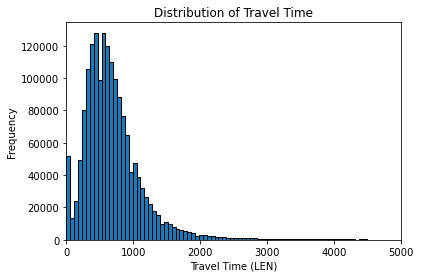

In [18]:
# Plotting the histogram
plt.hist(data['LEN'].dropna(), bins=1000, edgecolor='black')

# Adding labels and title
plt.xlabel('Travel Time (LEN)')
plt.ylabel('Frequency')
plt.title('Distribution of Travel Time')
plt.xlim(0, 5000)  

# Displaying the histogram
plt.show()

By looking at the data, we have decided to remove __outliers__ by setting lower and upper thresholds

In [19]:
threshold = 3000
minimum_len = 30
data = data[(data['LEN'] <= threshold) & (data['LEN'] >= minimum_len)]

We can now fill the NAs in the latitude and longitude by using the first value in the polyline. We considered using median inputation, but it did not provide very good results.

In [20]:
first_longitude = data['POLYLINE'].apply(lambda x: (x.split(',')[0])[2:])
data.loc[:,'Longitude'] = data['Longitude'].fillna(pd.Series(first_longitude))

In [21]:
first_latitude = data['POLYLINE'].apply(lambda x: (x.split(',')[1])[:-1])
data.loc[:,'Latitude'] = data['Latitude'].fillna(pd.Series(first_latitude))

With respect to the timestamp, it gets separated into different columns, but we will only keep the day of the week and the hour, since we think it is the only relevant information in this case.

In [22]:
data[["YR", "MON", "DAY", "HR", "WK"]] = data[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [23]:
data = data.drop('TIMESTAMP', axis=1)
data = data.drop('POLYLINE', axis=1)
data = data.drop('YR', axis=1)
#data = data.drop('MON', axis=1)
#data = data.drop('DAY', axis=1)
data = data.drop('TAXI_ID', axis = 1)

Finally, we have decided to group the hours of the day into intervals, since this makes it easier to have one-hot encoding:

In [24]:
bins = [-1, 4, 8, 12, 16, 20, 24]
labels = [0, 1, 2, 3, 4, 5]

data['HOUR_GROUP'] = pd.cut(data['HR'], bins=bins, labels=labels, include_lowest=True)
data.drop(['HR'], axis=1, inplace=True)
data

,CALL_TYPE,DAY_TYPE,Latitude,Longitude,LEN,MON,DAY,WK,HOUR_GROUP
0,C,A,41.141412,-8.618643,330,7,1,0,0
1,B,A,41.1599801853,-8.641984,270,7,1,0,0
2,C,A,41.140359,-8.612964,960,7,1,0,0
3,C,A,41.151951,-8.574678,630,7,1,0,0
4,C,A,41.18049,-8.645994,420,7,1,0,0
...,...,...,...,...,...,...,...,...,...
1710653,C,A,41.162283,-8.60697,2895,1,2,3,2
1710655,C,A,41.14602,-8.612469,465,6,30,0,5
1710656,C,A,41.140845,-8.610138,435,6,30,0,5
1710658,B,A,41.1551197292,-8.630466,915,6,30,0,3


In [25]:
data.dtypes

CALL_TYPE       object
DAY_TYPE        object
Latitude        object
Longitude       object
LEN              int64
MON              int64
DAY              int64
WK               int64
HOUR_GROUP    category
dtype: object

In [26]:
columns_to_convert = ['Latitude', 'Longitude']
data[columns_to_convert] = data[columns_to_convert].astype(float)
data['WK'] = data['WK'].astype('category')
data['MON'] = data['MON'].astype('category')
data['DAY'] = data['DAY'].astype('category')

In [27]:
data.dtypes

CALL_TYPE       object
DAY_TYPE        object
Latitude       float64
Longitude      float64
LEN              int64
MON           category
DAY           category
WK            category
HOUR_GROUP    category
dtype: object

In [28]:
# Split the data into training and testing sets
X = data.drop('LEN', axis=1)
y = data['LEN']

columns_to_scale = ['Latitude', 'Longitude']

#X_train_scaled = pd.get_dummies(X_train_scaled)
#X_test_scaled = pd.get_dummies(X_test_scaled)

X = pd.get_dummies(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the selected columns using StandardScaler
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train_scaled[columns_to_scale])
X_test_scaled[columns_to_scale] = scaler.transform(X_test_scaled[columns_to_scale])

In [29]:
X_train_scaled

,Latitude,Longitude,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,DAY_TYPE_A,MON_1,MON_2,MON_3,MON_4,...,WK_3,WK_4,WK_5,WK_6,HOUR_GROUP_0,HOUR_GROUP_1,HOUR_GROUP_2,HOUR_GROUP_3,HOUR_GROUP_4,HOUR_GROUP_5
501161,1.014090,0.270639,1,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1343474,0.316724,0.968837,0,0,1,1,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
645634,0.166485,-0.876497,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1243555,-0.457609,1.180897,0,1,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
1335076,-0.631203,0.372502,1,0,0,1,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266535,0.077907,0.900366,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1464454,0.123419,-0.726401,1,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
135699,0.317306,0.964704,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
690526,0.487070,1.762723,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Test preprocessing

In [30]:
test= pd.read_csv("test_public.csv")

In [31]:
test

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA
0,T1,B,NaN,15.0,20000542,1408039037,A,False
1,T2,B,NaN,57.0,20000108,1408038611,A,False
2,T3,B,NaN,15.0,20000370,1408038568,A,False
3,T4,B,NaN,53.0,20000492,1408039090,A,False
4,T5,B,NaN,18.0,20000621,1408039177,A,False
...,...,...,...,...,...,...,...,...
315,T323,A,70885.0,NaN,20000430,1419171485,A,False
316,T324,B,NaN,53.0,20000020,1419170802,A,False
317,T325,C,NaN,NaN,20000207,1419172121,A,False
318,T326,A,76232.0,NaN,20000667,1419171980,A,False


In [32]:
test = pd.merge(test, csv_df, left_on='ORIGIN_STAND', right_on='ID', how='left')

test.drop(['Descricao'], axis=1, inplace=True)
test.drop(['ID'], axis=1, inplace=True)

test[["YR", "MON", "DAY", "HR", "WK"]] = test[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

test = test.drop('MISSING_DATA', axis=1)
test = test.drop('TRIP_ID', axis=1)
#test = test.drop('CALL_TYPE', axis=1)
test = test.drop('ORIGIN_CALL', axis=1)
test['TAXI_ID']=test['TAXI_ID'].astype(str).str[-3:]
test.drop(['ORIGIN_STAND'], axis=1, inplace=True)

test = test.drop('TIMESTAMP', axis=1)
test = test.drop('YR', axis=1)
#test = test.drop('MON', axis=1)
#test = test.drop('DAY', axis=1)

bins = [-1, 4, 8, 12, 16, 20, 24]
labels = [0, 1, 2, 3, 4, 5]

test['HOUR_GROUP'] = pd.cut(test['HR'], bins=bins, labels=labels, include_lowest=True)
test.drop(['HR'], axis=1, inplace=True)

columns_to_convert = ['Latitude', 'Longitude']
test[columns_to_convert] = test[columns_to_convert].astype(float)
test['WK'] = test['WK'].astype('category')

columns_to_scale = ['Latitude', 'Longitude']
scaler = StandardScaler()
test[columns_to_scale] = scaler.fit_transform(test[columns_to_scale])

test = test.drop('TAXI_ID', axis = 1)

test['MON'] = test['MON'].astype('category')
test['DAY'] = test['DAY'].astype('category')

test = pd.get_dummies(test)

In [33]:
test

,Latitude,Longitude,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,DAY_TYPE_A,MON_8,MON_9,MON_10,MON_11,...,WK_1,WK_3,WK_5,WK_6,HOUR_GROUP_0,HOUR_GROUP_1,HOUR_GROUP_2,HOUR_GROUP_3,HOUR_GROUP_4,HOUR_GROUP_5
0,-0.547167,1.222430,0,1,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,-0.804739,0.061619,0,1,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,-0.547167,1.222430,0,1,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,-1.204164,-0.092900,0,1,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,-0.574317,-0.354287,0,1,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,NaN,NaN,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
316,-1.204164,-0.092900,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
317,NaN,NaN,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
318,NaN,NaN,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [34]:
# Get the column names in the training data
train_columns = X_train_scaled.columns

# Identify the missing columns in the test data
missing_columns = set(train_columns) - set(test.columns)

# Add the missing columns to the test data with default values
for column in missing_columns:
    test[column] = 0
    

In [35]:
test.isna().sum()

Latitude       197
Longitude      197
CALL_TYPE_A      0
CALL_TYPE_B      0
CALL_TYPE_C      0
              ... 
WK_2             0
MON_5            0
DAY_26           0
MON_7            0
MON_4            0
Length: 62, dtype: int64

In [36]:
#test['Latitude'] = test['Latitude'].fillna(0)
#test['Longitude'] = test['Longitude'].fillna(0)


test['Latitude'] = test['Latitude'].fillna(test['Latitude'].mean())
test['Longitude'] = test['Longitude'].fillna(test['Longitude'].mean())

In [37]:
test

,Latitude,Longitude,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,DAY_TYPE_A,MON_8,MON_9,MON_10,MON_11,...,DAY_9,DAY_15,DAY_27,DAY_8,DAY_2,WK_2,MON_5,DAY_26,MON_7,MON_4
0,-5.471671e-01,1.222430e+00,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-8.047393e-01,6.161901e-02,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-5.471671e-01,1.222430e+00,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-1.204164e+00,-9.289977e-02,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-5.743173e-01,-3.542866e-01,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,8.133692e-13,-3.103570e-14,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
316,-1.204164e+00,-9.289977e-02,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
317,8.133692e-13,-3.103570e-14,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
318,8.133692e-13,-3.103570e-14,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Fully connected neural network

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [39]:
# Convert the data to PyTorch tensors (we need to pass fropm Pandas to Numpy first)
X_train_scaled = X_train_scaled.to_numpy()
X_test_scaled = X_test_scaled.to_numpy()
y_train_scaled = y_train.to_numpy()
y_test_scaled = y_test.to_numpy()

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [40]:
# Move the data to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
print(device)

cuda


In [42]:
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.fc5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)
        self.fc6 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.6)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.bn2(x)
        x = F.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.bn4(x)
        x = F.relu(self.fc5(x))
        x = self.bn5(x)
        x = self.dropout(x)
        x = self.fc6(x)
        return x

100%|██████████| 660/660 [00:06<00:00, 109.43it/s]


Epoch 1/10, Loss: 612228.3535


100%|██████████| 660/660 [00:05<00:00, 113.20it/s]


Epoch 2/10, Loss: 464477.4457


100%|██████████| 660/660 [00:06<00:00, 107.97it/s]


Epoch 3/10, Loss: 291481.4616


100%|██████████| 660/660 [00:05<00:00, 117.72it/s]


Epoch 4/10, Loss: 193121.5649


100%|██████████| 660/660 [00:05<00:00, 122.97it/s]


Epoch 5/10, Loss: 166936.9197


100%|██████████| 660/660 [00:05<00:00, 122.33it/s]


Epoch 6/10, Loss: 164253.7790


100%|██████████| 660/660 [00:05<00:00, 122.98it/s]


Epoch 7/10, Loss: 163616.6599


100%|██████████| 660/660 [00:05<00:00, 122.99it/s]


Epoch 8/10, Loss: 163599.8080


100%|██████████| 660/660 [00:05<00:00, 122.49it/s]


Epoch 9/10, Loss: 163191.8985


100%|██████████| 660/660 [00:05<00:00, 123.16it/s]


Epoch 10/10, Loss: 163062.3607


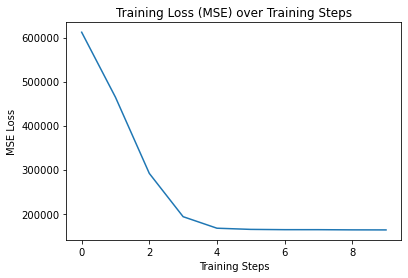

Test Loss: 154071.25


In [44]:
indv_losses = []
# Create an instance of the neural network model
input_size = X_train_tensor.shape[1]
model = NeuralNetwork(input_size)
model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.RMSprop(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
batch_size = 2000
num_batches = X_train_tensor.shape[0] // batch_size

train_losses = []  # To store training losses

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch in tqdm(range(num_batches)):
        start = batch * batch_size
        end = start + batch_size

        inputs = X_train_tensor[start:end]
        labels = y_train_tensor[start:end]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        
        indv_losses.append(loss.item())
        running_loss += loss.item()

    average_loss = running_loss / num_batches
    train_losses.append(average_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}')

# Visualize the training loss over training steps
plt.plot(train_losses)
plt.xlabel('Training Steps')
plt.ylabel('MSE Loss')
plt.title('Training Loss (MSE) over Training Steps')
plt.show()

# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    loss = criterion(outputs.squeeze(), y_test_tensor)
print('Test Loss:', loss.item())

In [45]:
# Sample submission file that is given on kaggle
df_sample_nn = pd.read_csv("sampleSubmission.csv")

val = scaler.fit_transform(test)
x_val = torch.tensor(val, dtype=torch.float32)
x_val = x_val.to(device)

# Move the model to the GPU
model = model.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Turn off gradient calculation
with torch.no_grad():
    # Make predictions with the model on the GPU
    predictions = model(x_val)

# Move the predictions back to the CPU
predictions = predictions.cpu()

# Convert the predictions to a numpy array
predictions = predictions.numpy()

# Assign the predictions to the "TRAVEL_TIME" column
df_sample_nn["TRAVEL_TIME"] = predictions
# mean(716.43) -> 792.73593
# median(600) -> 784.74219
df_sample_nn.to_csv("my_pred_MLP_7.csv", index=None)
df_sample_nn

,TRIP_ID,TRAVEL_TIME
0,T1,491.329193
1,T2,548.141235
2,T3,491.329193
3,T4,583.972839
4,T5,535.087402
...,...,...
315,T323,716.502991
316,T324,650.277832
317,T325,698.187378
318,T326,716.502991


## XGBoost

In [46]:
import xgboost as xgb

# Define the grid of hyperparameters to search
#param_grid = {
#    "eta": [0.1, 0.3, 0.5],
#    "max_depth": [3, 5, 7],
#    "subsample": [0.8, 0.9],
#    "colsample_bytree": [0.8, 0.9]
#}

param_grid = {'colsample_bytree': [0.9], 'eta': [0.3], 'max_depth': [7], 'subsample': [0.9]}

num_boost_round = 300

# Create the XGBoost model
xgb_model = xgb.XGBRegressor()

# Perform grid search
#grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring="neg_root_mean_squared_error", cv=3)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring="neg_root_mean_squared_error", cv=2)

grid_search.fit(X_train_scaled, y_train)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Train the best model on the full training set
best_model.fit(X_train_scaled, y_train)

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test_scaled)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE on test set: {rmse}")
print("Best parameters:", best_params)

RMSE on test set: 385.7312396990384
Best parameters: {'colsample_bytree': 0.9, 'eta': 0.3, 'max_depth': 7, 'subsample': 0.9}


In [47]:
# Make predictions on the new dataset
predictions_xgb = best_model.predict(test)

# Sample submission file that is given on kaggle
df_sample_nn = pd.read_csv("sampleSubmission.csv")

# Assign the predictions to the "TRAVEL_TIME" column
df_sample_nn["TRAVEL_TIME"] = predictions_xgb
df_sample_nn.to_csv("my_pred_xgb4.csv", index=None)
df_sample_nn

,TRIP_ID,TRAVEL_TIME
0,T1,599.427063
1,T2,652.481812
2,T3,599.427063
3,T4,753.940247
4,T5,675.051147
...,...,...
315,T323,697.458984
316,T324,788.788513
317,T325,766.528442
318,T326,697.458984
